In [1]:
%pylab inline

# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation.JSAnimation import IPython_display
from matplotlib import animation

import numpy as np

from intern.remote.boss import BossRemote
from intern.resource.boss.resource import ChannelResource


Populating the interactive namespace from numpy and matplotlib


## Setup `intern` Remote Instance

Create an instance of the Boss Python SDK intern.  You need to provide configuration details to the library.

- Copy `./boss.cfg.example` to `./boss.cfg`
- Get your API Token: https://api.theboss.io/token
- Copy and paste your API token into `./boss.cfg`

In [2]:
rmt = BossRemote("./boss.cfg")

## Create a Channel Resource

We interact with the Boss via "resources" which represent how data is organized in the Boss.  `Channels` store image data.  Let's create

In [69]:
# Create a resource for the channel you want to access. Let's use a publically available dataset
collection_name = "cmu_test2"
experiment_name = "cmu_exp3"
channel_name = "cmu_test_ch3"
channel = ChannelResource(channel_name, collection_name, experiment_name)
channel = rmt.get_project(channel)

## Set Cutout Arguments
Set the spatial extent for the cutout.  Here we are doing a cutout of non-time series data, but if the channel you were accessing contained multiple time samples, you could simply add a time range to the query.  See the `intern` docs for more detail:

- Wiki: https://github.com/jhuapl-boss/intern/wiki
- Docs: https://jhuapl-boss.github.io/intern/
- Examples: https://github.com/jhuapl-boss/intern/tree/master/examples

In [86]:
x_rng = [0, 512]
y_rng = [0, 512]
z_rng = [1, 2] # z range should be = 1, visualizing a time series
t_rng = [40, 80]
time_data = rmt.get_cutout(channel, 0, x_rng, y_rng, z_rng, t_rng)
time_data.shape

(40, 1, 512, 512)

In [87]:
hist_data = np.histogram(time_data, bins=20)
min_val = hist_data[1][0]
max_val = hist_data[1][-3]

In [88]:
# Method to window a 16-bit image
def window_img(image, min_val, max_val):
    image_scaled = zeros(image.shape)
    np.clip(image, min_val, max_val, out=image_scaled)
    np.subtract(image_scaled, min_val, out=image_scaled)
    #return np.multiply( image_scaled,np.iinfo(np.uint16).max/(max_val-min_val),out=image_scaled)
    return np.multiply(image_scaled,255./(max_val-min_val),out=image_scaled).astype(np.uint8)

# Window dynamic channel cutout
time_data = window_img(time_data, min_val, max_val)


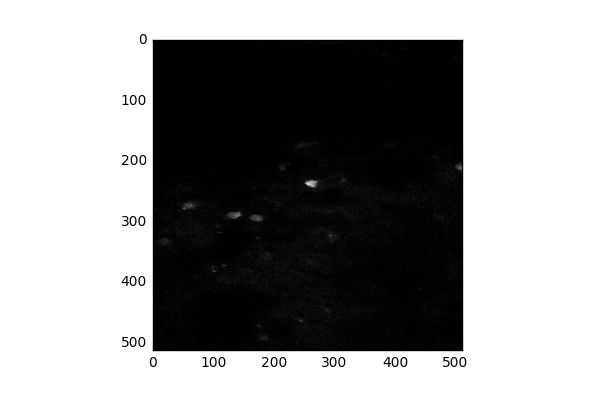
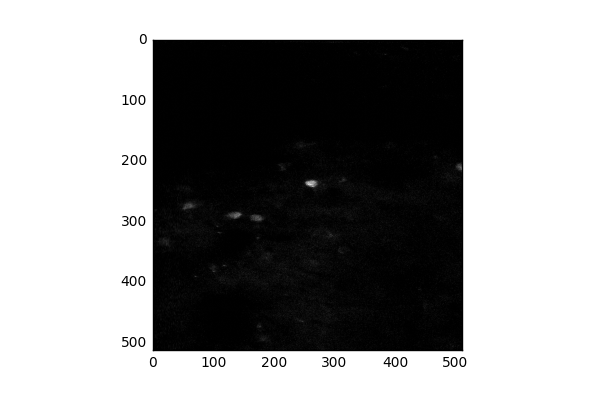
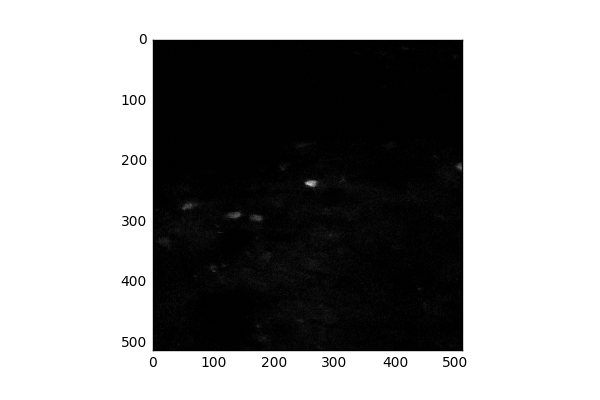
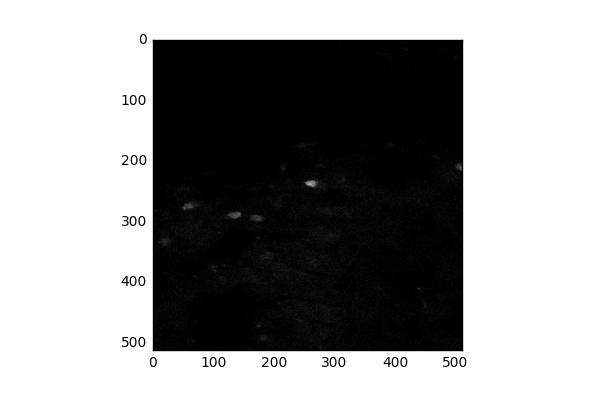
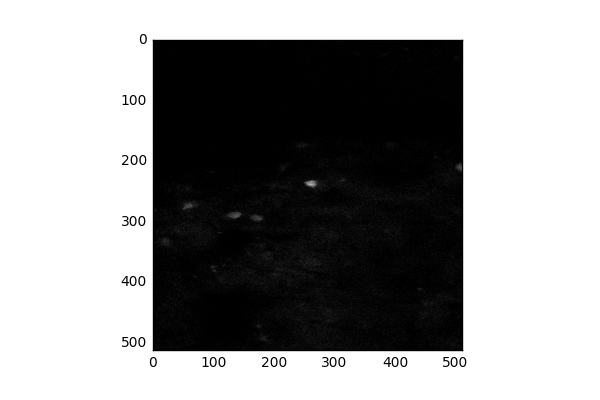
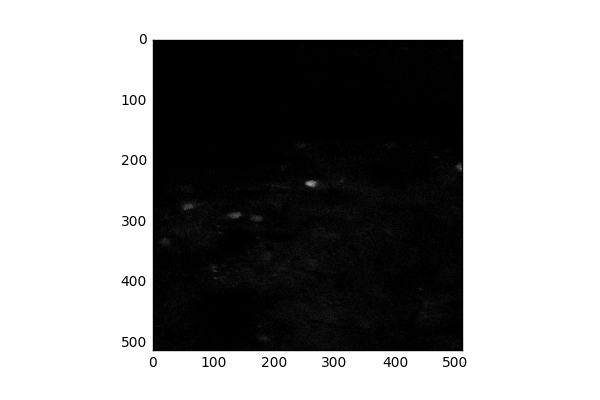
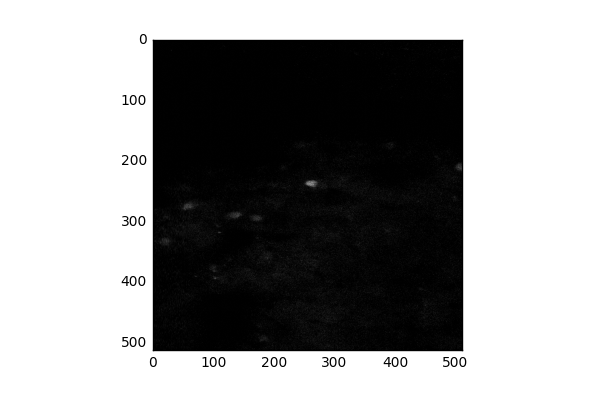
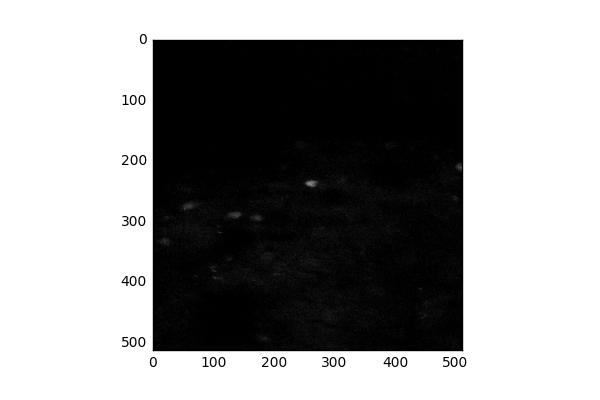
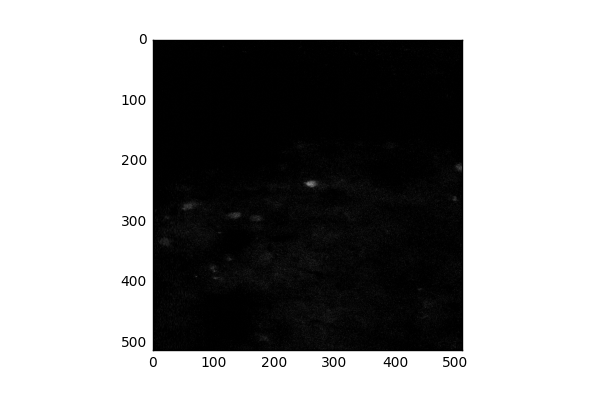
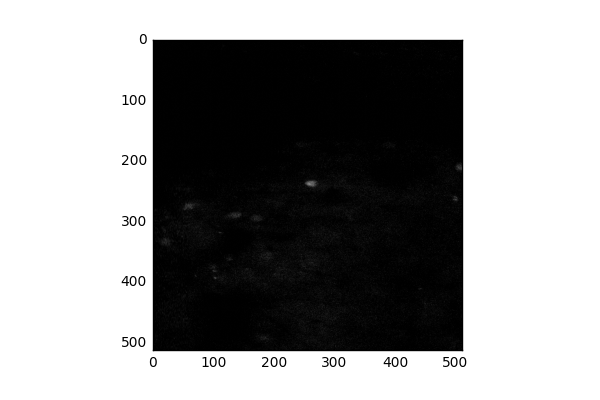
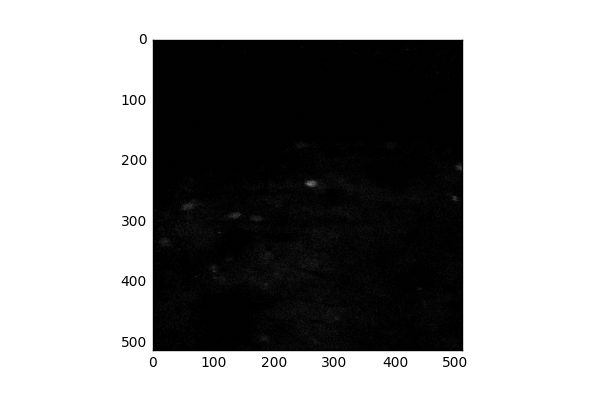
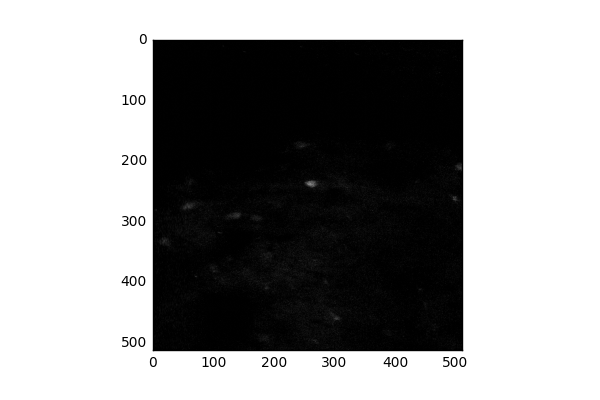
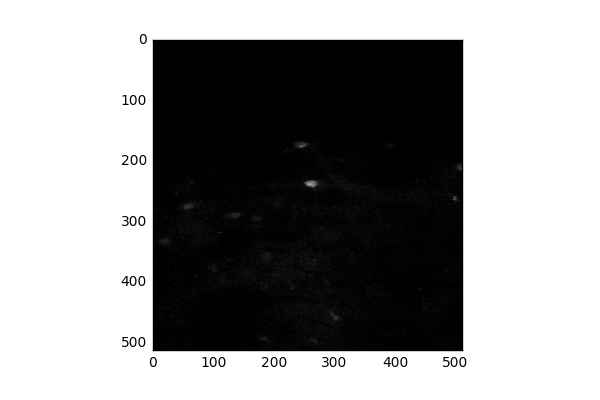
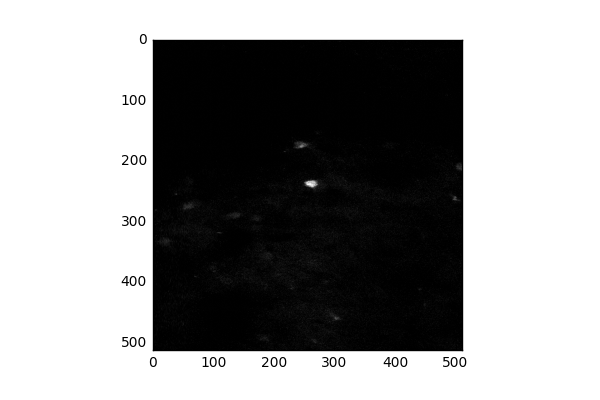
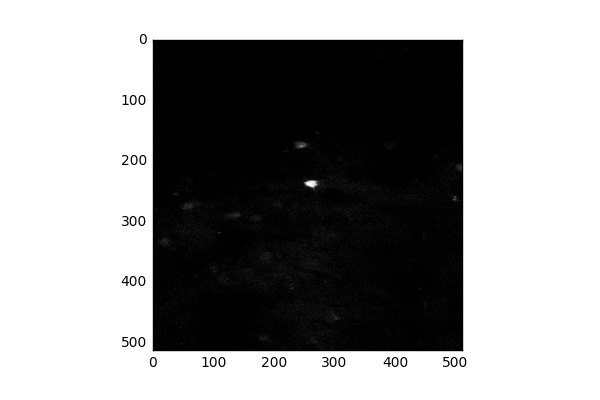
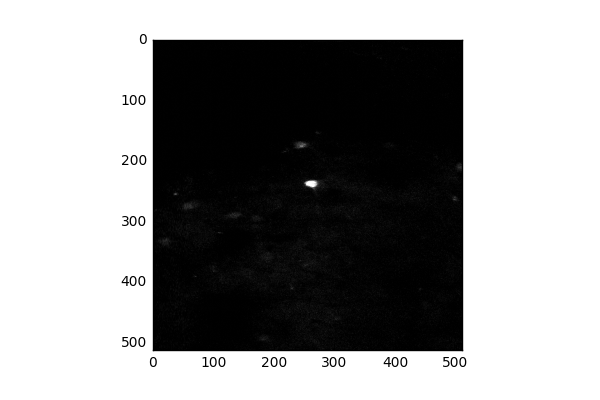
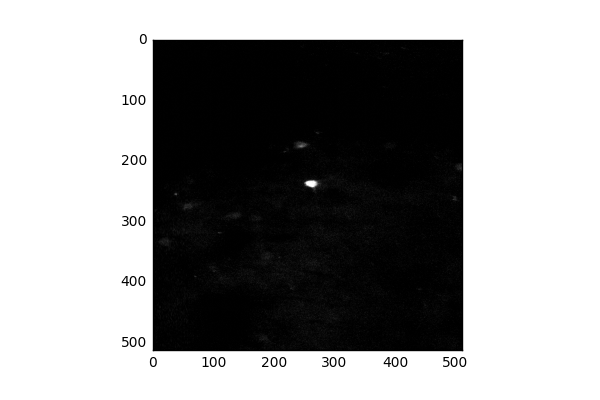
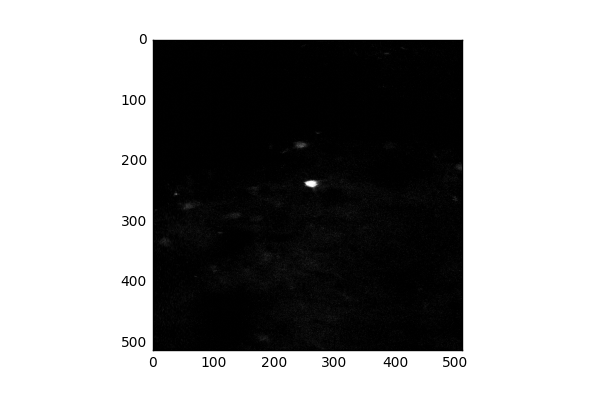
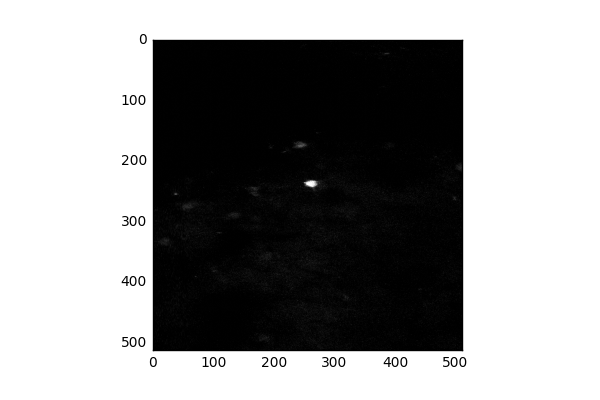
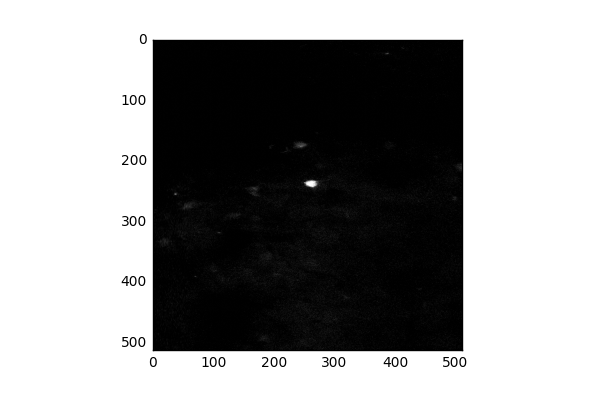
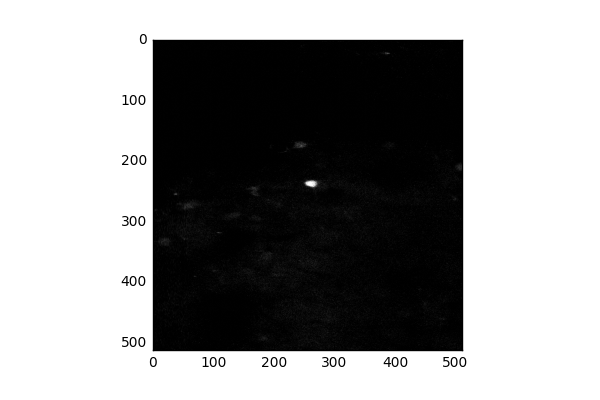
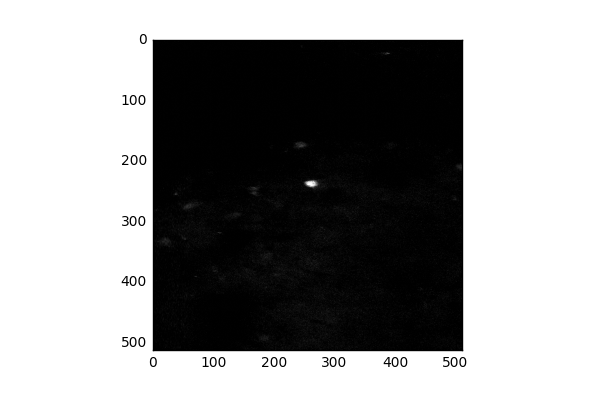
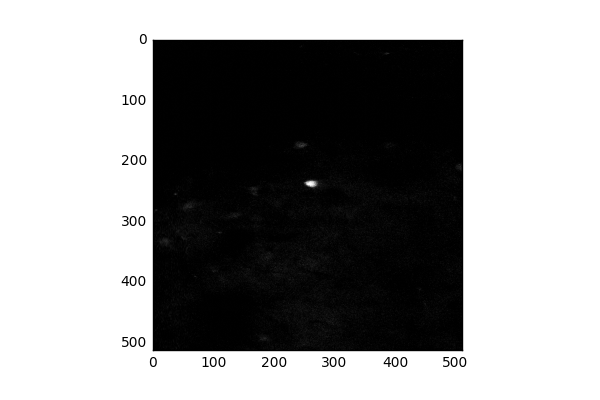
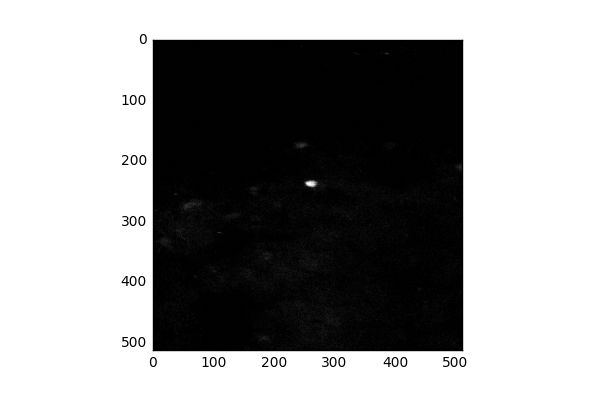
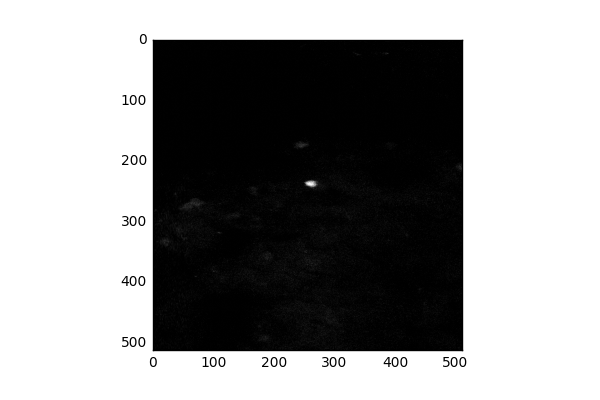
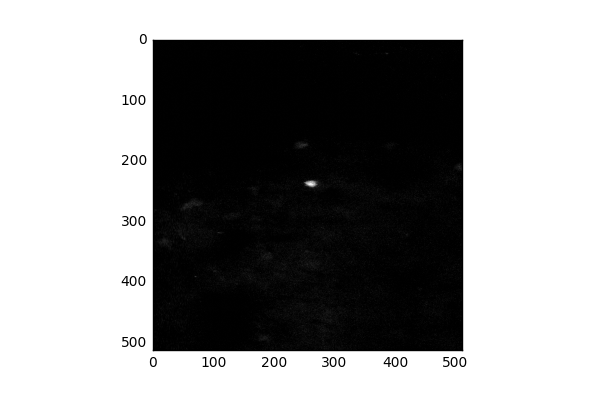
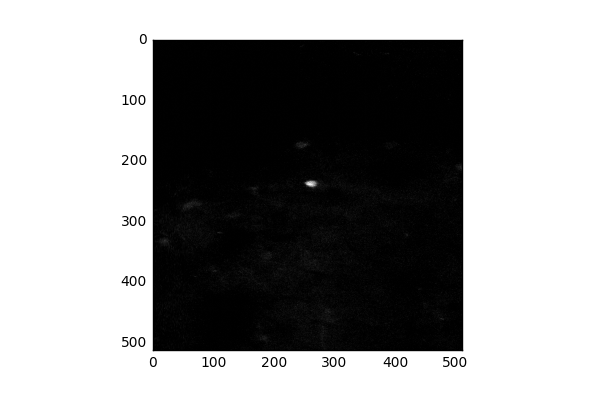
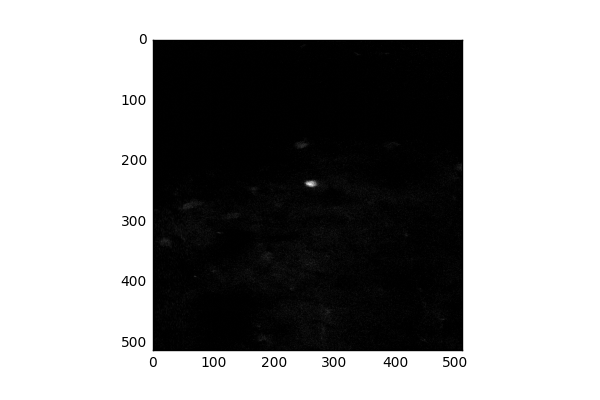
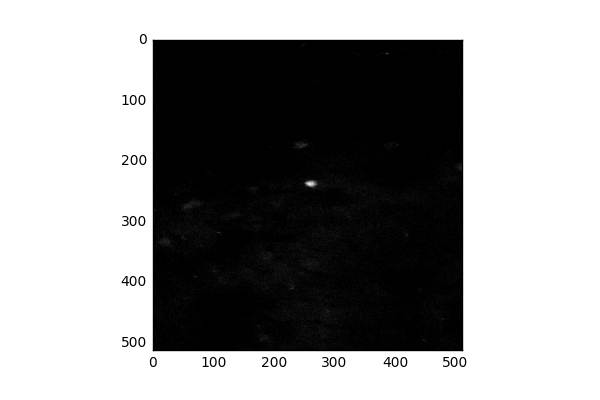
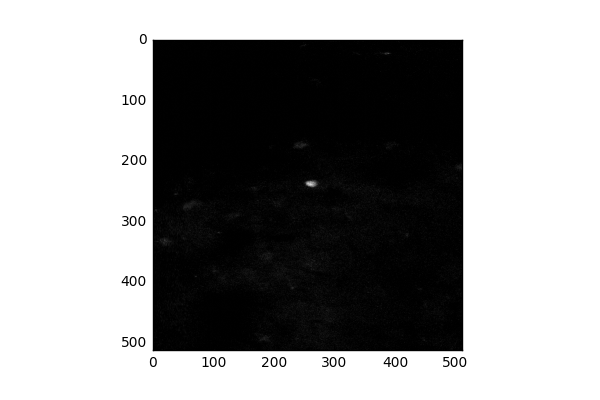
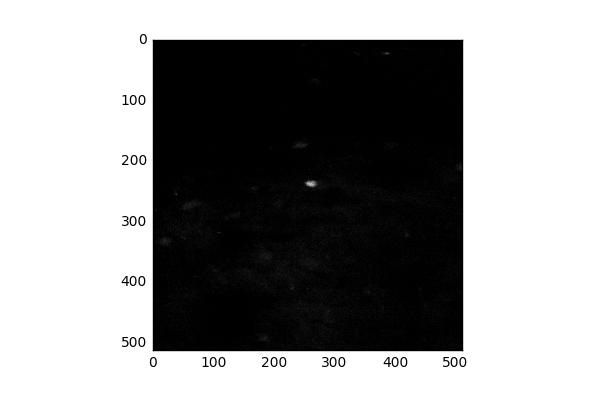
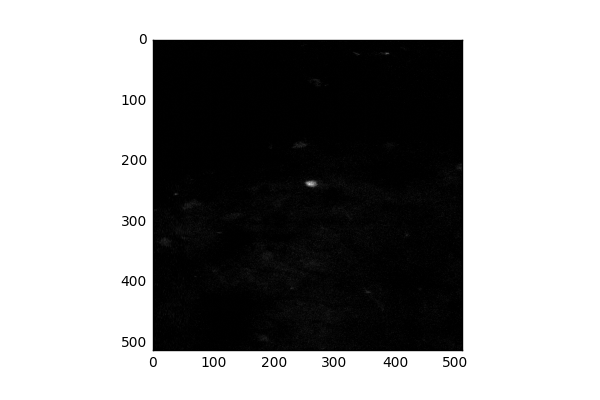
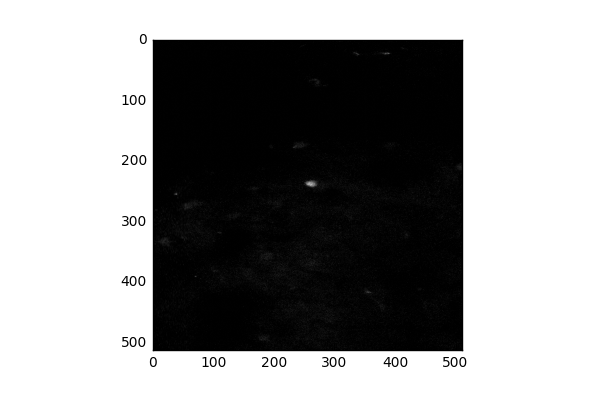
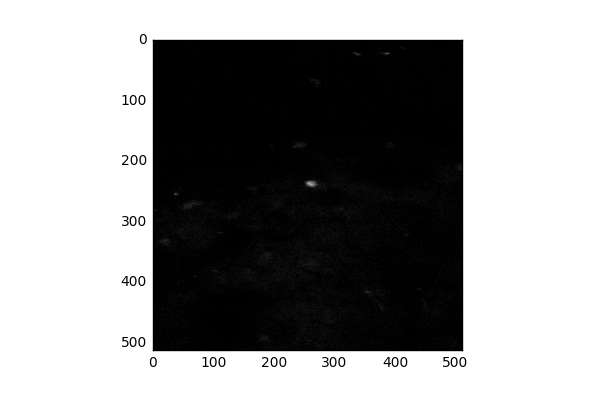
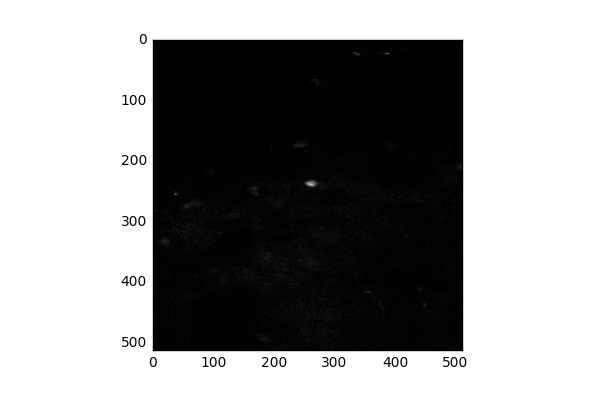
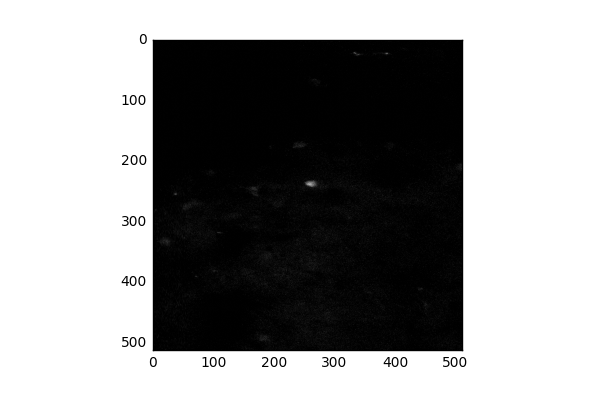
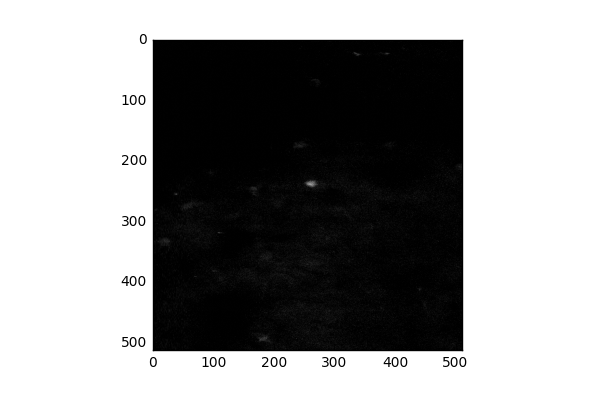
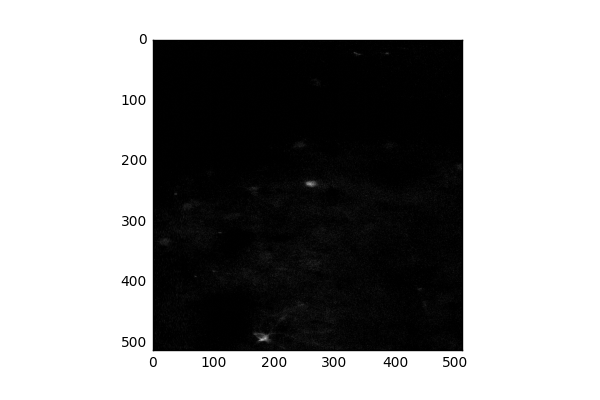
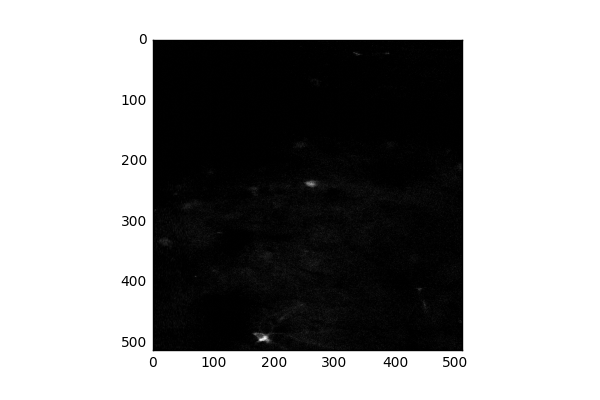
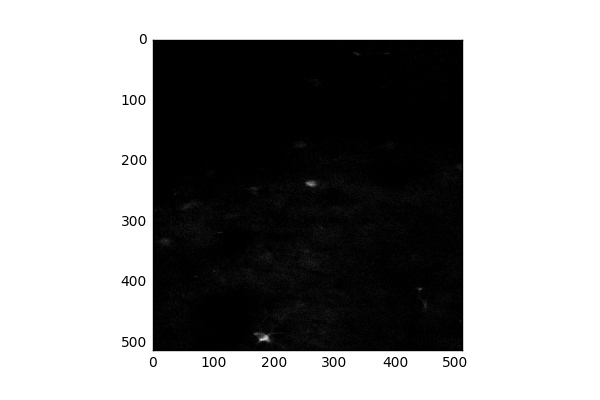

In [89]:
fig = plt.figure()
im = plt.imshow(time_data[1,0,:,:], cmap=plt.cm.gray, interpolation='bicubic') 

def init():
    im.set_data(time_data[1,0,:,:])

def animate(i): 
    im.set_data(time_data[i,0,:,:])
    return im

animation.FuncAnimation(fig, animate, init_func=init, frames=time_data.shape[0],
                               interval=75)